In [650]:
#%matplotlib inline
#%matplotlib notebook
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.debugger import set_trace
from time import time 
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_moons
from sklearn.utils import shuffle
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import load_svmlight_files
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import math
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
import os
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import warnings
warnings.filterwarnings('ignore')


In [651]:
class sentimental_analysis:
    
    def load_files(self, files):
        return load_svmlight_files(files, n_features=None, dtype=None)

    # Calculating Tf-Idf for training and testing
    def tfidf(self, training_data, testing_data):
        tf_transformer = TfidfTransformer()

        print("Training_data TF-IDF")
        #  It computes the TF for each review, the IDF using each review, and finally the TF-IDF for each review
        training_data_tfidf = tf_transformer.fit_transform(training_data)
        print(training_data_tfidf.shape)

        print("Testing_data TF-IDF")
        # .transform on the testing data which computes the TF for each review, 
        # then the TF-IDF for each review using the IDF from the training data 
        testing_data_tfidf = tf_transformer.transform(testing_data)
        print(testing_data_tfidf.shape)

        return [training_data_tfidf,testing_data_tfidf]

    # Binerize target data

    # Converting target into binary
    def binerize (self, raw_target):    
        binerize_target = []
        for i in range(len(raw_target)):
            if raw_target[i] > 5:
                binerize_target.append(1) # Positive
            else:
                binerize_target.append(0) # Negative
        return binerize_target

In [652]:
# Store path in array for training and testing files
files = ["./aclImdb/train/labeledBow.feat","./aclImdb/test/labeledBow.feat"]

# Object for sentiment_analysis
sa = sentimental_analysis()

# Load data for training_data, training_target and testing_data, testing_target 
training_data, raw_training_target, testing_data, raw_testing_target = sa.load_files(files)


In [653]:
training_label = np.array(sa.binerize(raw_training_target))
testing_label = np.array(sa.binerize(raw_testing_target))

In [654]:
class logisticRegression:
    
    # defining parameters such as learning rate, number ot iterations, whether to include intercept, 
    # and verbose which says whether to print anything or not like, loss etc.
    def __init__(self, learning_rate=0.01, num_iterations=1000, fit_intercept=True, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        
    
    # function to define the Incercept value.
    def __b_intercept(self, X):
        # initially we set it as all 1's
        intercept = np.ones((X.shape[0], 1))
        # then we concatinate them to the value of X, we don't add we just append them at the end.
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid_function(self, z):
        # this is our actual sigmoid function which predicts our yp
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, yp, y):
        # this is the loss function which we use to minimize the error of our model
        return (-y * np.log(yp) - (1 - y) * np.log(1 - yp)).mean()

    def getW(self):
        return self.W

    # this is the function which trains our model.
    def fit(self, X, y):
        losses_train = np.zeros(self.num_iterations)

        # as said if we want our intercept term to be added we use fit_intercept=True
        if self.fit_intercept:
            X = self.__b_intercept(X)
        
        # weights initialization of our Normal Vector, initially we set it to 0, then we learn it eventually
        self.W = np.zeros(X.shape[1])
        
        # this for loop runs for the number of iterations provided
        for i in range(self.num_iterations):
            
            # this is our W * Xi
            z = np.dot(X, self.W)
            
            # this is where we predict the values of Y based on W and Xi
            yp = self.__sigmoid_function(z)
            
            # this is where the gradient is calculated form the error generated by our model
            gradient = np.dot(X.T, (yp - y)) / y.size
            
            # this is where we update our values of W, so that we can use the new values for the next iteration
            self.W -= self.learning_rate * gradient
            
            # this is our new W * Xi
            z = np.dot(X, self.W)
            yp = self.__sigmoid_function(z)
            
            # this is where the loss is calculated
            loss = self.__loss(yp, y)
            losses_train[i] = loss
            # as mentioned above if we want to print somehting we use verbose, so if verbose=True then our loss get printed
            if(self.verbose ==True and i % 10000 == 0):
                print(f'loss: {loss} \t')

        return losses_train
    
    # this is where we predict the probability values based on out generated W values out of all those iterations.
    def predict_prob(self, X):
        # as said if we want our intercept term to be added we use fit_intercept=True
        if self.fit_intercept:
            X = self.__b_intercept(X)
        
        # this is the final prediction that is generated based on the values learned.
        return self.__sigmoid_function(np.dot(X, self.W))
    
    # this is where we predict the actual values 0 or 1 using round. anything less than 0.5 = 0 or more than 0.5 is 1
    def predict(self, X):
        return self.predict_prob(X).round()
        

### Z-Score

In [655]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stops = set(stopwords.words('english'))
print(len(stops))

179


[nltk_data] Downloading package stopwords to C:\Users\shima
[nltk_data]     mihannezhad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [656]:
words_df = pd.read_csv("aclImdb\\imdb.vocab", header=None, names=['words'],dtype=str)
words_df

,words
0,the
1,and
2,a
3,of
4,to
...,...
89522,copywrite
89523,artbox
89524,kinky-sex
89525,urrrghhh


In [657]:
df_NOindx=words_df[words_df.words.isin(stops)!=True]
df_NOindx

,words
15,movie
17,film
26,one
27,!
36,like
...,...
89522,copywrite
89523,artbox
89524,kinky-sex
89525,urrrghhh


In [658]:
#Create Matrix
import numpy as np
from scipy.sparse import csr_matrix

tmp=0
y_train=[]
with open('aclImdb\\train\\labeledBow.feat') as f:
    lines=f.readlines()   # do not process the header line
    train_mtrx=csr_matrix((len(lines), len(words_df.index)), dtype=np.uint8).toarray()
    for line in lines:
      items=line.split(" ")
      y_train.append(int(items[0]))
      for j in items[1:]:
        word,cnt=j.split(":")
        #print(type(word),cnt)
        train_mtrx[int(tmp),int(word)]=cnt
      tmp=tmp+1

train_mtrx.shape

(25000, 89527)

In [659]:
tmp=0
y_test=[]
with open('aclImdb\\test\\labeledBow.feat') as f:
    lines=f.readlines()   # do not process the header line
    test_mtrx=csr_matrix((len(lines), len(words_df.index)), dtype=np.uint8).toarray()
    for line in lines:
      items=line.split(" ")
      y_test.append(int(items[0]))
      for j in items[1:]:
        word,cnt=j.split(":")
        #print(type(word),cnt)
        test_mtrx[int(tmp),int(word)]=cnt
      tmp=tmp+1

test_mtrx.shape

(25000, 89527)

In [660]:
#index of Non stop words
non_stp_indx=list(words_df[words_df.words.isin(stops)!=True].index)
len(non_stp_indx)

89356

In [661]:
train_mtrx=train_mtrx[:,non_stp_indx]
test_mtrx = test_mtrx[:,non_stp_indx]

In [662]:
#Normalize Matrix

for col in range(train_mtrx.shape[1]):
  col_means = np.mean(train_mtrx[:,col])
  col_stv = np.std(train_mtrx[:,col])
  #print(mtrx[:,col])
  train_mtrx[:,col]=(train_mtrx[:,col]-col_means)/col_stv
  #print(mtrx[:,col],col_means,col_stv)

In [663]:
#Normalize Matrix

for col in range(test_mtrx.shape[1]):
  col_means = np.mean(test_mtrx[:,col])
  col_stv = np.std(test_mtrx[:,col])
  #print(mtrx[:,col])
  test_mtrx[:,col]=(test_mtrx[:,col]-col_means)/col_stv

In [664]:
train_mtrx.shape

(25000, 89356)

In [665]:
#Normalize y
col_means = np.mean(y_train)
col_stv = np.std(y_train)
#print(y)
y_train=(y_train-col_means)/col_stv

In [666]:
dt_train=np.dot(train_mtrx.transpose(),y_train)/math.sqrt(train_mtrx.shape[0])
print(dt_train.shape)
dt_train

(89356,)


array([-7.83338294,  2.37012529,  1.63004577, ...,  1.30366158,
        1.30366158, -0.42599016])

In [667]:
dt2_train=np.absolute(dt_train)#absolute values
max_index=(-dt2_train).argsort()[0:300]#Get index of 300 max
max=dt2_train[max_index]
print(max)
max_index

[32.38688265 27.82736491 27.47911296 23.98982467 22.20933949 21.64597294
 21.58175542 20.8356732  20.17108598 18.58175073 18.37368654 17.88041132
 17.66626934 17.23137863 17.01094086 17.00913254 17.00059769 16.92943237
 16.74898904 16.45979383 16.34611316 16.3426189  16.18704212 16.13471279
 15.66469124 15.47498172 15.35863783 15.21315762 15.18320596 15.17391576
 15.16947596 15.12952823 14.73699406 14.69558583 14.68596926 14.54161281
 14.51999049 14.43828882 14.18396068 14.17623125 14.08848558 13.96212307
 13.94355223 13.89033347 13.87573389 13.26821101 12.89094711 12.8378957
 12.76247442 12.67806749 12.54831602 12.49471097 12.41224563 12.33103578
 12.31797684 12.27807246 12.27209742 12.16620646 12.04013412 12.01574085
 12.01042418 12.01040389 11.87492771 11.86430517 11.67137653 11.58009543
 11.57106767 11.5655087  11.56046637 11.4830951  11.42293475 11.41211749
 11.26589821 11.167013   11.13147128 11.09392959 11.05273885 10.98422654
 10.95908426 10.92833186 10.8434931  10.78391031 10.

array([ 138,  257,  312,  262,  258,  307,   17,  462,  386,  633,  252,
        200,  727,  344,   39,   19,  124,  234,  280,  971,  499,  294,
        322,  740,  882,    5, 1136,   38,  376,  218,  408,  686, 1045,
       1063,  476, 1467,  767,  162,  120,  621, 1117,  190,  391,  324,
        775,   63,   34, 1151,  372, 1109, 1477, 1153,  738,  230,  128,
       1757,   40,  459,  371,  104,  567, 1674,   36,  608, 2156,  819,
        612,  785,  821,  115,  999,  824,  840, 2300, 1223, 1488, 1977,
        405,  641,  444, 2379,  260, 1039, 2129, 1940,  761,  672, 2278,
       1457,  394, 1010, 1191,  123,  578, 1122,  822, 2135, 1804,  791,
        187, 1051,  469, 3093, 2979,   23, 1155, 2912, 1884, 1704, 1325,
        461, 2044, 2109,  165,  431,  532, 1684,   58, 1969,  428, 3967,
       1132,  884, 2431,  276,  236, 1024, 1702, 1537,   24,  244, 1247,
       1367,  601, 3380, 2209,  660,  900,  880,  351,  358, 2113, 2597,
        465,  448, 2146,  275, 1099, 1447, 1341, 35

In [668]:
test_mtrx.shape

(25000, 89356)

In [669]:
train_mtrx = train_mtrx[:,max_index]
test_mtrx = test_mtrx[:,max_index]
print(train_mtrx.shape, test_mtrx.shape)

(25000, 300) (25000, 300)


In [670]:
#df_NOindx.iloc[max_index]
words_df.loc[max_index]

,words
138,something
257,trying
312,idea
262,place
258,goes
...,...
399,finally
1042,escape
2004,national
682,british


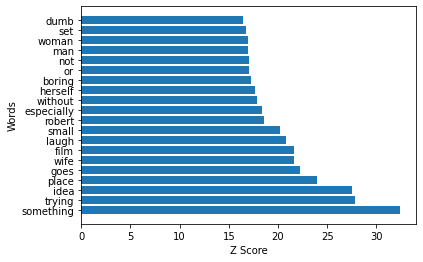

In [671]:
Product = list(words_df.loc[max_index[:20]].words)
Quantity = max[:20]

plt.barh(Product,Quantity)
plt.title('')
plt.ylabel('Words')
plt.xlabel('Z Score')
plt.show()

### Logistic Regresion

In [672]:
model = logisticRegression()
losses_train = model.fit(train_mtrx,training_label)
label_pred = model.predict(test_mtrx)
accuracy_score(testing_label,label_pred)

0.85024

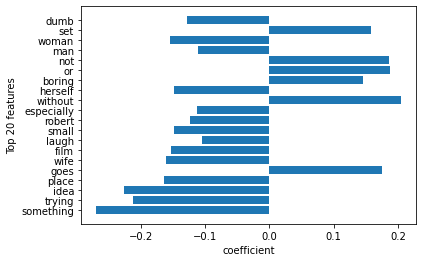

In [673]:
Product = list(words_df.loc[max_index[:20]].words)
Quantity = model.getW()[1:21]


plt.barh(Product,Quantity)
plt.title('')
plt.ylabel('Top 20 features')
plt.xlabel('coefficient')
plt.show()


training_label = np.expand_dims(training_label, axis=-1)
testing_label = np.expand_dims(testing_label, axis=-1)

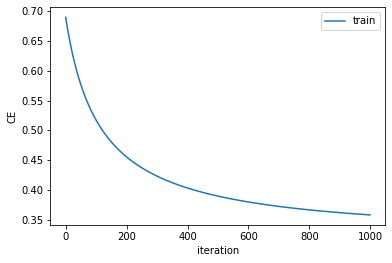

In [674]:
plt.clf()
plt.plot(losses_train, label='train')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

### KNN

In [675]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_model = knn.fit(train_mtrx,training_label)
knn_pred = knn.predict(test_mtrx)
accuracy_score(testing_label,knn_pred)

0.75396

### AUROC

In [676]:
models = [LogisticRegression(),
          KNeighborsClassifier()]

In [677]:
perf = {}

# our implementation is slow you may try sklearn version
model = logisticRegression()
scratch_train = model.fit(train_mtrx,training_label)
label_pred = model.predict(test_mtrx)
fpr, tpr, _ = roc_curve(testing_label, label_pred)
auroc = roc_auc_score(testing_label, label_pred)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit_func = model.fit(train_mtrx, training_label)
    y_test_prob = model.predict_proba(test_mtrx)[:,1]
    fpr, tpr, _ = roc_curve(testing_label, y_test_prob)
    auroc = roc_auc_score(testing_label, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}

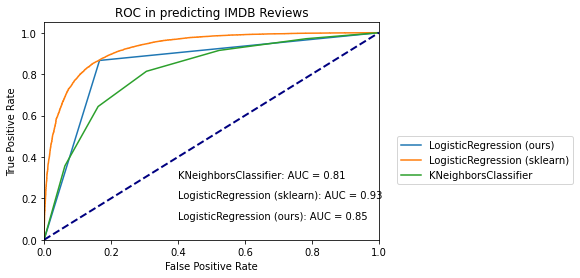

In [678]:
plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting IMDB Reviews')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
# plt.close()

In [679]:
train_mtrx, training_label = shuffle(train_mtrx, training_label)
test_mtrx, testing_label = shuffle(test_mtrx, testing_label)

In [680]:
train_text = train_mtrx[:5000,:]
train_label = training_label[:5000]

test_text = test_mtrx[:5000,:]
test_label = testing_label[:5000]

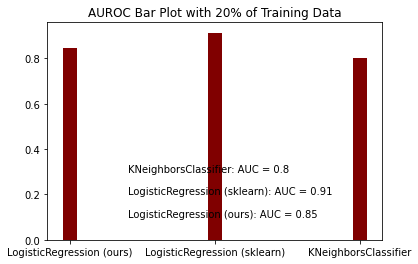

In [681]:
perf = {}
i = 0
# our implementation is slow you may try sklearn version
model = logisticRegression()
scratch_train = model.fit(train_text, train_label)
label_pred = model.predict(test_text)
fpr, tpr, _ = roc_curve(test_label, label_pred)
auroc = roc_auc_score(test_label, label_pred)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit_func = model.fit(train_text, train_label)
    y_test_prob = model.predict_proba(test_text)[:,1]
    fpr, tpr, _ = roc_curve(test_label, y_test_prob)
    auroc = roc_auc_score(test_label, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
        
for model_name, model_perf in perf.items():
    plt.bar(model_name, model_perf['auroc'], color ='maroon',width = 0.1) 
    plt.title("AUROC Bar Plot with 20% of Training Data")        
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

In [682]:
train_text = train_mtrx[:10000,:]
train_label = training_label[:10000]

test_text = test_mtrx[:10000,:]
test_label = testing_label[:10000]

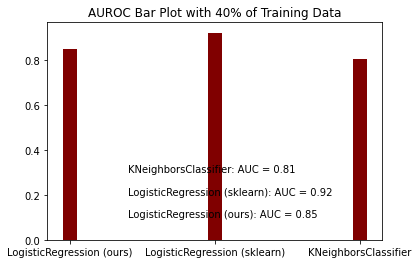

In [683]:
perf = {}
i = 0
# our implementation is slow you may try sklearn version
model = logisticRegression()
scratch_train = model.fit(train_text, train_label)
label_pred = model.predict(test_text)
fpr, tpr, _ = roc_curve(test_label, label_pred)
auroc = roc_auc_score(test_label, label_pred)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit_func = model.fit(train_text, train_label)
    y_test_prob = model.predict_proba(test_text)[:,1]
    fpr, tpr, _ = roc_curve(test_label, y_test_prob)
    auroc = roc_auc_score(test_label, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
        
for model_name, model_perf in perf.items():
    plt.bar(model_name, model_perf['auroc'], color ='maroon',width = 0.1) 
    plt.title("AUROC Bar Plot with 40% of Training Data")   
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

In [684]:
train_text = train_mtrx[:15000,:]
train_label = training_label[:15000]

test_text = test_mtrx[:15000,:]
test_label = testing_label[:15000]

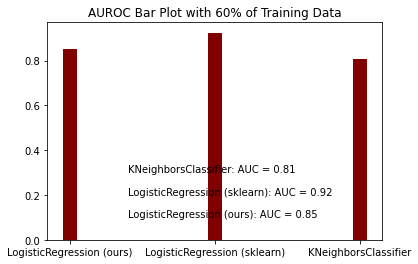

In [685]:
perf = {}
i = 0
# our implementation is slow you may try sklearn version
model = logisticRegression()
scratch_train = model.fit(train_text, train_label)
label_pred = model.predict(test_text)
fpr, tpr, _ = roc_curve(test_label, label_pred)
auroc = roc_auc_score(test_label, label_pred)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit_func = model.fit(train_text, train_label)
    y_test_prob = model.predict_proba(test_text)[:,1]
    fpr, tpr, _ = roc_curve(test_label, y_test_prob)
    auroc = roc_auc_score(test_label, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
        
for model_name, model_perf in perf.items():
    plt.bar(model_name, model_perf['auroc'], color ='maroon',width = 0.1) 
    plt.title("AUROC Bar Plot with 60% of Training Data")   
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

In [686]:
train_text = train_mtrx[:20000,:]
train_label = training_label[:20000]

test_text = test_mtrx[:20000,:]
test_label = testing_label[:20000]

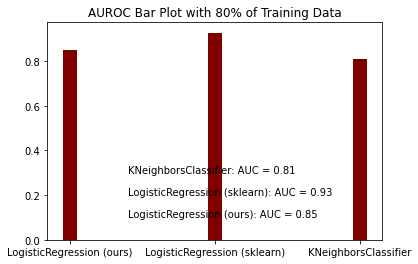

In [687]:
perf = {}
i = 0
# our implementation is slow you may try sklearn version
model = logisticRegression()
scratch_train = model.fit(train_text, train_label)
label_pred = model.predict(test_text)
fpr, tpr, _ = roc_curve(test_label, label_pred)
auroc = roc_auc_score(test_label, label_pred)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit_func = model.fit(train_text, train_label)
    y_test_prob = model.predict_proba(test_text)[:,1]
    fpr, tpr, _ = roc_curve(test_label, y_test_prob)
    auroc = roc_auc_score(test_label, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
        
for model_name, model_perf in perf.items():
    plt.bar(model_name, model_perf['auroc'], color ='maroon',width = 0.1) 
    plt.title("AUROC Bar Plot with 80% of Training Data") 
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

In [688]:
train_text = train_mtrx[:,:]
train_label = training_label[:]

test_text = test_mtrx[:,:]
test_label = testing_label[:]

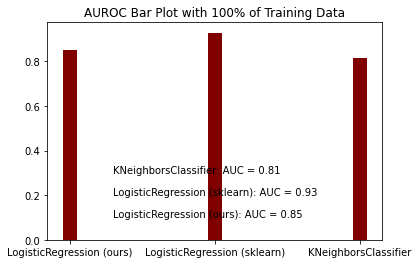

In [689]:
perf = {}
i = 0
# our implementation is slow you may try sklearn version
model = logisticRegression()
scratch_train = model.fit(train_text, train_label)
label_pred = model.predict(test_text)
fpr, tpr, _ = roc_curve(test_label, label_pred)
auroc = roc_auc_score(test_label, label_pred)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit_func = model.fit(train_text, train_label)
    y_test_prob = model.predict_proba(test_text)[:,1]
    fpr, tpr, _ = roc_curve(test_label, y_test_prob)
    auroc = roc_auc_score(test_label, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
        
for model_name, model_perf in perf.items():
    plt.bar(model_name, model_perf['auroc'], color ='maroon',width = 0.1) 
    plt.title("AUROC Bar Plot with 100% of Training Data") 
    plt.text(0.3, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1  

### Another Approach

In [690]:
train = os.path.join('train')
train_labels = []
train_texts = []
for label_type in ['neg','pos']:
    dir_n = os.path.join(train,label_type) 
    print('Loading ',label_type)
    for fname in tqdm(os.listdir(dir_n)):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_n,fname),encoding='utf8')
            train_texts.append(f.read())
            f.close()
            if label_type == 'neg':
                train_labels.append(0)
            else:
                train_labels.append(1)      

Loading  neg


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:55<00:00, 227.19it/s]


Loading  pos


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:57<00:00, 217.26it/s]


In [691]:
train = os.path.join('test')
test_labels = []
test_texts = []
for label_type in ['neg','pos']:
    dir_n = os.path.join(train,label_type) 
    print('Loading ',label_type)
    for fname in tqdm(os.listdir(dir_n)):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_n,fname),encoding='utf8')
            test_texts.append(f.read())
            f.close()
            if label_type == 'neg':
                test_labels.append(0)
            else:
                test_labels.append(1)  

Loading  neg


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:55<00:00, 226.08it/s]


Loading  pos


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:24<00:00, 514.32it/s]


In [692]:
from nltk.tokenize.toktok import ToktokTokenizer
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [693]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]','', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [694]:
from bs4 import BeautifulSoup
import re
#Apply function on review column
for index,comment in enumerate(train_texts):
    train_texts[index] = denoise_text(comment)
    
for index,comment in enumerate(test_texts):
    test_texts[index] = denoise_text(comment)

In [695]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    text=re.sub(r'[\n\r\t]','',text)
    text=re.sub(r'[^a-zA-Z0-9\s]','',text)
    return text

#Apply function on review column
for index,comment in enumerate(train_texts):
    train_texts[index] = remove_special_characters(comment)
    
for index,comment in enumerate(test_texts):
    test_texts[index] = remove_special_characters(comment)
    

In [696]:
#lemmatizing the text
def simple_lemmatizer(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    text= ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split()])
    return text
#Apply function on review column
for index,comment in enumerate(train_texts):
    train_texts[index] = simple_lemmatizer(comment)
    
for index,comment in enumerate(test_texts):
    test_texts[index] = simple_lemmatizer(comment)

In [697]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
for index,comment in enumerate(train_texts):
    train_texts[index] = simple_stemmer(comment)
    
for index,comment in enumerate(test_texts):
    test_texts[index] = simple_stemmer(comment)

In [698]:
#set stopwords to english
stop=set(stopwords.words('english'))

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
for index,comment in enumerate(train_texts):
    train_texts[index] = remove_stopwords(comment)
    
for index,comment in enumerate(test_texts):
    test_texts[index] = remove_stopwords(comment)

In [699]:
#Count vectorizer for bag of words
bag=CountVectorizer(min_df=0.15,max_df=0.5,binary=False,ngram_range=(1,3))
#transformed train reviews
bow_train_reviews=bag.fit_transform(train_texts)
#transformed test reviews
bow_test_reviews=bag.transform(test_texts)

print('BOW_train:',bow_train_reviews.shape)
print('BOW_test:',bow_test_reviews.shape)

BOW_train: (25000, 75)
BOW_test: (25000, 75)


In [700]:
#Tfidf vectorizer
Tfidf=TfidfVectorizer(min_df=0.15,max_df=0.5,use_idf=True,ngram_range=(1,3))
#transformed train reviews
Tfidf_train_reviews=Tfidf.fit_transform(train_texts)
#transformed test reviews
Tfidf_test_reviews=Tfidf.transform(test_texts)

print('Tfidf_train:',Tfidf_train_reviews.shape)
print('Tfidf_test:',Tfidf_test_reviews.shape)

Tfidf_train: (25000, 75)
Tfidf_test: (25000, 75)


In [701]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
train_labels_data=lb.fit_transform(train_labels)
test_labels_data=lb.fit_transform(test_labels)

print(train_labels_data.shape)
print(test_labels_data.shape)

(25000, 1)
(25000, 1)


In [702]:
from sklearn import linear_model

reg = linear_model.LogisticRegression()
lr_bow_train = reg.fit(bow_train_reviews,train_labels)
lr_bow_predict=reg.predict(bow_test_reviews)
lr_tfidf_train = reg.fit(Tfidf_train_reviews,train_labels)
lr_tfidf_predict=reg.predict(Tfidf_test_reviews)

print(accuracy_score(test_labels,lr_tfidf_predict))
print(accuracy_score(test_labels,lr_bow_predict))

0.73528
0.73592


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_bow_train = knn.fit(bow_train_reviews,train_labels)
knn_bow_predict = knn.predict(bow_test_reviews)
knn_tfidf_train = knn.fit(Tfidf_train_reviews,train_labels)
knn_tfidf_predict = knn.predict(Tfidf_test_reviews)

print(accuracy_score(test_labels,knn_tfidf_predict))
print(accuracy_score(test_labels,knn_bow_predict))